# Training UNet for drop segmentation

In [154]:
import torch
from checkpoints import *
from measures import *

In [155]:
config = {
    "lr": 0.002,
    "batch_size": 16,
    "epochs": 65,
    "threshold": 0.3,
    "init_from_checkpoint": False,
    "input_mode": "RGBD",
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "cg_checkpoints",
    "checkpoint": "UNetRGBDBCEt30v32e60.pt", # if None loads last saved checkpoint
    "print_model": False,
    "binarization": True,
    "seed": 3407 # if None uses random seed
}

config["channels"] = len(config["input_mode"])
print(f"Training using {config['device']}")

Training using cuda


In [ ]:
def parse_mode(mode, depth=4):
    extras=[0] * 4
    in_channels = 0
    for c in mode:
        if c in 'RGBHSVP':
            in_channels = in_channels + 1
        elif c == 'D':
            dwt = [0, 3, 3, 3]
            extras = 

In [156]:
# Set seed
if config["seed"] is not None:
    torch.manual_seed(config["seed"])  

In [157]:
def random_split(dataset, val_percent=0.15, test_percent=0.15):
    val_size = int(len(dataset) * val_percent)
    test_size = int(len(dataset) * test_percent)
    train_size = len(dataset) - val_size - test_size
    return torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [158]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    mode=config["input_mode"],
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    binarization = config["binarization"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset, test_dataset = random_split(dataset, 0.1, 0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val:   {len(val_dataset)} images, {len(val_loader)} batches')
print (f'Test:  {len(test_dataset)} images, {len(test_loader)} batches')

Loaded 836 images

Train: 670 images, 42 batches
Val:   83 images, 6 batches
Test:  83 images, 6 batches


In [159]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet, RUNet
from unet import init_weights
from pathlib import Path
from torch.optim import lr_scheduler

model = UNet(config["channels"]).to(config['device'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=config["lr"])

# Load or fill weights
# And set the start_epoch of model
best_checkpoint = None
if config["init_from_checkpoint"]:
    # Load checkpoint
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    best_checkpoint = checkpoint
    
    # Load model & optim from checkpoint
    model.load_state_dict(checkpoint["model_state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

scheduler = lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[8, 16, 32, 64],
    gamma=0.63
)

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [160]:
def validate(model, loss_fn):
    import math
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    ious = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            
            
            if not math.isnan(loss.item()):
                losses.append(loss.item())
            else:
                print("Nan on validation")
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            if config["binarization"]:
                pred = (pred >= config["threshold"])
            
            accuracies.append(accuracy(y, pred))
            ious.append(IoU(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
    model.train()         
    mean = lambda l: sum(l) / len(l) if len(l) > 0 else -1
    return mean(losses), mean(ious), mean(accuracies), mean(precisions), mean(recalls)

In [161]:
def ch_score(checkpoint):
    return checkpoint["iou"]

In [162]:
if not config["init_from_checkpoint"]:
    best_checkpoint = {
        "name": "nullcheck",
        "epochs": 0,
        "model_state_dict": [],
        "optimizer_state_dict": [],
        "train_loss": 1e100,
        "val_loss": 1e100,
        "iou": 0,
        "accuracy": 0,
        "precision": 0,
        "recall": 0
    }

In [163]:
from tqdm.notebook import tqdm
from sys import stdout
import math
import wandb
from datetime import datetime


def train(save_checkpoints=True, lr=None):
    # If lr=None, learning rate is used from optimizer
    if lr is not None:
        optimizer.param_groups[0]["lr"] = lr
    global best_checkpoint

    # Start wandb
    wandb.init(
        name="Run" + str(datetime.now()),
        project="water-drop-detection",
        config={
        "learning_rate": config["lr"],
        "architecture": "UNet",
        "dataset": "Stereo",
        "epochs": config["epochs"],
        "checkpoint": best_checkpoint
        }
    )
    
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch, "| lr", optimizer.state_dict()["param_groups"][0]["lr"])
        
        loader = tqdm(train_loader)
        losses = []

        # Training this epoch
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                if math.isnan(torch.max(pred)):
                    print(f"NaN pred occured")
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            train_loss = loss.item()
            if math.isnan(train_loss):
                print(f"NaN loss occured")
                return
            
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)
            
        optimizer.step()
        scheduler.step()


        # Compute metrics
        train_loss = sum(losses) / len(losses)
        checkpoint = get_checkpoint( 
                model,
                config["input_mode"],
                optimizer,
                loss_fn,
                epoch,
                train_loss,
                *validate(model, loss_fn)
            )
        print_checkpoint(checkpoint)

        wandb.log({"checkpoint": checkpoint})
        
        if save_checkpoints:
            save_checkpoint(
                checkpoint,
                config["checkpoint_dir"],
                checkpoint["name"]
            )
        # Find best checkpoint
        elif ch_score(best_checkpoint) < ch_score(checkpoint):
            best_checkpoint = checkpoint
    wandb.finish()

In [164]:
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 0 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.859589410679681
Valid BCE loss: 0.6163646678129832
IoU:       0.23442004734857214 

Accuracy:  0.45119343863593203
Precision: 0.7375665681643618
Recall:    0.2734193890209629 

Epoch 1 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.5753425998347146
Valid BCE loss: 0.5419776191314062
IoU:       0.2674820277219017 

Accuracy:  0.6654767460293239
Precision: 0.5178833800342141
Recall:    0.3760223995514942 

Epoch 2 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.5454333140736535
Valid BCE loss: 0.5171832193930944
IoU:       0.2851651821078526 

Accuracy:  0.6307108667161729
Precision: 0.6462087202687851
Recall:    0.36264344099170215 

Epoch 3 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.5239376993406386
Valid BCE loss: 0.5203200578689575
IoU:       0.31028902460820973 

Accuracy:  0.5980300903320312
Precision: 0.802455369900498
Recall:    0.3469541041404718 

Epoch 4 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.49608765968254637
Valid BCE loss: 0.5622455775737762
IoU:       0.30563568556681275 

Accuracy:  0.5460232098897299
Precision: 0.870965720878707
Recall:    0.3294791444789332 

Epoch 5 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.47996889693396433
Valid BCE loss: 0.4673460125923157
IoU:       0.3244693140602774 

Accuracy:  0.7659066518147787
Precision: 0.5271924318771603
Recall:    0.5359574272855534 

Epoch 6 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.46063545488175894
Valid BCE loss: 0.4430537124474843
IoU:       0.39945125119346714 

Accuracy:  0.7905306816101074
Precision: 0.5953892528907293
Recall:    0.6118497094097136 

Epoch 7 | lr 0.002


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4565679281949997
Valid BCE loss: 0.4329422513643901
IoU:       0.383177424263623 

Accuracy:  0.7578490045335559
Precision: 0.6666249260306358
Recall:    0.5294951563885156 

Epoch 8 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4379591594139735
Valid BCE loss: 0.43641509115695953
IoU:       0.4091415641725891 

Accuracy:  0.7475701438056098
Precision: 0.7389267648880681
Recall:    0.5062626406479961 

Epoch 9 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4303889175256093
Valid BCE loss: 0.42723168929417926
IoU:       0.4432079328560374 

Accuracy:  0.8045654296875
Precision: 0.6095437080366537
Recall:    0.6424350475787619 

Epoch 10 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4187133219980058
Valid BCE loss: 0.3897865066925685
IoU:       0.43275091067577404 

Accuracy:  0.8018465042114258
Precision: 0.6734700824341012
Recall:    0.570393193770078 

Epoch 11 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4213345121769678
Valid BCE loss: 0.4745843360821406
IoU:       0.388371059903875 

Accuracy:  0.6751568052503797
Precision: 0.8360173978532354
Recall:    0.42625384135968947 

Epoch 12 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4079137927009946
Valid BCE loss: 0.41007543603579205
IoU:       0.4366659756698128 

Accuracy:  0.7801871829562717
Precision: 0.7098622565519892
Recall:    0.5574185315451395 

Epoch 13 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4068951670612608
Valid BCE loss: 0.41516783833503723
IoU:       0.44928013621312046 

Accuracy:  0.7731378343370227
Precision: 0.7519680078969233
Recall:    0.5440502974727471 

Epoch 14 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.41087902940454935
Valid BCE loss: 0.4040104200442632
IoU:       0.46226879866379833 

Accuracy:  0.7745613521999783
Precision: 0.7788540920656589
Recall:    0.5504630713776887 

Epoch 15 | lr 0.00126


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4016359519390833
Valid BCE loss: 0.3778735448916753
IoU:       0.45028143412330085 

Accuracy:  0.8048928048875598
Precision: 0.750304117384884
Recall:    0.551273084701842 

Epoch 16 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.4010161729086013
Valid BCE loss: 0.4005829046169917
IoU:       0.4408958881265587 

Accuracy:  0.8258624076843262
Precision: 0.5905833319346938
Recall:    0.6546067554250441 

Epoch 17 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3962045269353049
Valid BCE loss: 0.3604580859343211
IoU:       0.4493944928981364 

Accuracy:  0.8291669421725802
Precision: 0.6689437205592791
Recall:    0.5983277438959647 

Epoch 18 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.39219445770695094
Valid BCE loss: 0.38276374340057373
IoU:       0.4678652507459952 

Accuracy:  0.8073205418056912
Precision: 0.7341202089252571
Recall:    0.5848111786380167 

Epoch 19 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3786950657765071
Valid BCE loss: 0.36447273194789886
IoU:       0.45909997370714944 

Accuracy:  0.8064618640475802
Precision: 0.7433217993626992
Recall:    0.5715663158405441 

Epoch 20 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.39600057687078205
Valid BCE loss: 0.419404278198878
IoU:       0.420771092047087 

Accuracy:  0.7264972262912326
Precision: 0.8310361949519979
Recall:    0.46860831625520905 

Epoch 21 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3845115580729076
Valid BCE loss: 0.36884671946366626
IoU:       0.46360358187100953 

Accuracy:  0.8103660477532281
Precision: 0.7261864944723331
Recall:    0.5749430605575822 

Epoch 22 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3826189303681964
Valid BCE loss: 0.38914617399374646
IoU:       0.47330440394580364 

Accuracy:  0.7701978153652616
Precision: 0.8260932452976704
Recall:    0.5284193023069661 

Epoch 23 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3661155565863564
Valid BCE loss: 0.3829335769017537
IoU:       0.4597571473051276 

Accuracy:  0.8048101001315646
Precision: 0.7361120030076967
Recall:    0.579414054928378 

Epoch 24 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.376120626216843
Valid BCE loss: 0.3857138355573018
IoU:       0.48242969971357125 

Accuracy:  0.826004876030816
Precision: 0.6615596533132097
Recall:    0.6731640562846478 

Epoch 25 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3808080880414872
Valid BCE loss: 0.37282341221968335
IoU:       0.4666977990677373 

Accuracy:  0.7923058403862847
Precision: 0.7487649110456308
Recall:    0.5738833727928686 

Epoch 26 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3739234201964878
Valid BCE loss: 0.39214785893758136
IoU:       0.47251064107856816 

Accuracy:  0.8143050935533312
Precision: 0.6865370010750161
Recall:    0.6299302770553061 

Epoch 27 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.37506231381779626
Valid BCE loss: 0.3612060099840164
IoU:       0.45935500382135314 

Accuracy:  0.7917564180162219
Precision: 0.7830648576426836
Recall:    0.5424383991509659 

Epoch 28 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.37341325055985225
Valid BCE loss: 0.33776917060216266
IoU:       0.5132187003166312 

Accuracy:  0.8380551868014865
Precision: 0.7457456869176693
Recall:    0.6352378461411836 

Epoch 29 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3611522238878977
Valid BCE loss: 0.38657577832539874
IoU:       0.4609010846664508 

Accuracy:  0.7841011153327094
Precision: 0.747246862285667
Recall:    0.5757736268704696 

Epoch 30 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.358078780628386
Valid BCE loss: 0.3929562568664551
IoU:       0.501850854139775 

Accuracy:  0.8236902554829916
Precision: 0.659522099679129
Recall:    0.6898169544517927 

Epoch 31 | lr 0.0007938


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3630395183960597
Valid BCE loss: 0.36504750450452167
IoU:       0.4587574107313736 

Accuracy:  0.7771697574191623
Precision: 0.8355332610921727
Recall:    0.5111430699223629 

Epoch 32 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.35598933554831
Valid BCE loss: 0.34361959000428516
IoU:       0.4895362247092028 

Accuracy:  0.8160370720757378
Precision: 0.7748650559224188
Recall:    0.5933439950179428 

Epoch 33 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.35402682210717884
Valid BCE loss: 0.34726719558238983
IoU:       0.48370590298953986 

Accuracy:  0.8158499929640027
Precision: 0.7729429905820223
Recall:    0.5820540583397547 

Epoch 34 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.35179885086559115
Valid BCE loss: 0.3736431648333867
IoU:       0.46702576966749293 

Accuracy:  0.7722726927863227
Precision: 0.8279771434350146
Recall:    0.5306938449171443 

Epoch 35 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3612031184491657
Valid BCE loss: 0.37429943184057873
IoU:       0.49597703080831307 

Accuracy:  0.795512835184733
Precision: 0.7895102052845888
Recall:    0.5788362071686267 

Epoch 36 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3592829753955205
Valid BCE loss: 0.3461816708246867
IoU:       0.48732961921228307 

Accuracy:  0.8090740309821235
Precision: 0.7864081292516656
Recall:    0.5728902413221222 

Epoch 37 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.352873831987381
Valid BCE loss: 0.33783644437789917
IoU:       0.4807447940693237 

Accuracy:  0.836616939968533
Precision: 0.7180772234116577
Recall:    0.6021257508288606 

Epoch 38 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.35196775836603983
Valid BCE loss: 0.3456932306289673
IoU:       0.49388769662214654 

Accuracy:  0.8197957144843208
Precision: 0.7529065497995665
Recall:    0.6081680500204935 

Epoch 39 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.349432823913438
Valid BCE loss: 0.3513963172833125
IoU:       0.48664864372565514 

Accuracy:  0.8080336252848307
Precision: 0.7723685794820389
Recall:    0.5849563459255946 

Epoch 40 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3416159578732082
Valid BCE loss: 0.34386638800303143
IoU:       0.49059733383667964 

Accuracy:  0.8193371031019422
Precision: 0.7697526681133442
Recall:    0.5878029175173681 

Epoch 41 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.34227243278707775
Valid BCE loss: 0.32727373639742535
IoU:       0.4910605603622065 

Accuracy:  0.8423085742526584
Precision: 0.6972638343771299
Recall:    0.6435960675316008 

Epoch 42 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.352909083877291
Valid BCE loss: 0.3932049622138341
IoU:       0.5009464192100698 

Accuracy:  0.8417843182881674
Precision: 0.632403092355364
Recall:    0.719930801407913 

Epoch 43 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3454717866012028
Valid BCE loss: 0.3643210728963216
IoU:       0.4843729623955571 

Accuracy:  0.7781285179985894
Precision: 0.8493881980992026
Recall:    0.5334692647185408 

Epoch 44 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.34574143233753385
Valid BCE loss: 0.3265589897831281
IoU:       0.5155740477041239 

Accuracy:  0.8426583078172473
Precision: 0.7405759446943799
Recall:    0.6490926536734973 

Epoch 45 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.34225537521498545
Valid BCE loss: 0.35200758775075275
IoU:       0.49148370128952795 

Accuracy:  0.8008098072475858
Precision: 0.8206898185114065
Recall:    0.5570403179244826 

Epoch 46 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3467114589044026
Valid BCE loss: 0.35144715507825214
IoU:       0.4918478183551795 

Accuracy:  0.8193833563062879
Precision: 0.7532851098415753
Recall:    0.6032474844418951 

Epoch 47 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3328181299425307
Valid BCE loss: 0.3553094615538915
IoU:       0.5012783829329742 

Accuracy:  0.8095812797546387
Precision: 0.7830916151611341
Recall:    0.5914641083417762 

Epoch 48 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.34113559410685584
Valid BCE loss: 0.34083398183186847
IoU:       0.5090217269543145 

Accuracy:  0.8388725916544596
Precision: 0.7048855309064189
Recall:    0.654795280767022 

Epoch 49 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3410296787818273
Valid BCE loss: 0.35284458100795746
IoU:       0.5069449378125783 

Accuracy:  0.8559204207526313
Precision: 0.6551879608693222
Recall:    0.7136951996435347 

Epoch 50 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.33672850117796943
Valid BCE loss: 0.34100956718126935
IoU:       0.5163621044096848 

Accuracy:  0.8282398647732205
Precision: 0.7729817663008968
Recall:    0.6145298683607054 

Epoch 51 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.33764744372594924
Valid BCE loss: 0.34184468785921734
IoU:       0.488137175846431 

Accuracy:  0.8526891072591146
Precision: 0.6525284469696796
Recall:    0.6886512441481575 

Epoch 52 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.344394183584622
Valid BCE loss: 0.3456725776195526
IoU:       0.5164319469800426 

Accuracy:  0.8359562026129829
Precision: 0.7385368532915083
Recall:    0.632770812966217 

Epoch 53 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.33849017251105534
Valid BCE loss: 0.3369908978541692
IoU:       0.5004254857906038 

Accuracy:  0.8356769349839953
Precision: 0.7294827310575379
Recall:    0.6380118928807781 

Epoch 54 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.34202295754637035
Valid BCE loss: 0.3464028040568034
IoU:       0.5122874173749652 

Accuracy:  0.8219495879279243
Precision: 0.7761608517418305
Recall:    0.6066987616055313 

Epoch 55 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.33517366860594067
Valid BCE loss: 0.34686251481374103
IoU:       0.5163399490217367 

Accuracy:  0.845644579993354
Precision: 0.6877406841764847
Recall:    0.6912151882844605 

Epoch 56 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.34272301764715285
Valid BCE loss: 0.3792222738265991
IoU:       0.5208987660913004 

Accuracy:  0.8234193060133191
Precision: 0.7245226667986976
Recall:    0.6693915037457504 

Epoch 57 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.33367623672598884
Valid BCE loss: 0.3448273489872615
IoU:       0.47784052675382954 

Accuracy:  0.7943415641784668
Precision: 0.8220940318165554
Recall:    0.5424722693271683 

Epoch 58 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3265148504149346
Valid BCE loss: 0.3326830367247264
IoU:       0.5116365110605127 

Accuracy:  0.8603313763936361
Precision: 0.6663229414779279
Recall:    0.7146914454173033 

Epoch 59 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.32833429106644224
Valid BCE loss: 0.3228843758503596
IoU:       0.5368642531749275 

Accuracy:  0.8548038800557455
Precision: 0.7390847008468376
Recall:    0.6776802192062199 

Epoch 60 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.32906327077320646
Valid BCE loss: 0.3338697950045268
IoU:       0.5099810585897002 

Accuracy:  0.8119905789693197
Precision: 0.8272028299462465
Recall:    0.5786233066168731 

Epoch 61 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3280711252064932
Valid BCE loss: 0.324810450275739
IoU:       0.4751967848278582 

Accuracy:  0.813891781700982
Precision: 0.8028809974590937
Recall:    0.5394555306163136 

Epoch 62 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.32814831889811014
Valid BCE loss: 0.3287235846122106
IoU:       0.5440959767438471 

Accuracy:  0.8552399211459689
Precision: 0.709864588868287
Recall:    0.7079733920308643 

Epoch 63 | lr 0.000500094


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3294838961391222
Valid BCE loss: 0.3677008847395579
IoU:       0.47362437125088436 

Accuracy:  0.7655221091376411
Precision: 0.8820181977417735
Recall:    0.5095783831507368 

Epoch 64 | lr 0.00031505922


  0%|          | 0/42 [00:00<?, ?it/s]

Train BCE loss: 0.3279873824545315
Valid BCE loss: 0.32860228916009265
IoU:       0.5192175263331996 

Accuracy:  0.8262916670905219
Precision: 0.7991396966907712
Recall:    0.6014076786856867 



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [151]:
wandb.finish()

In [152]:
print_checkpoint(best_checkpoint)

Train BCE loss: 0.3221676214819863
Valid BCE loss: 0.3197641223669052
IoU:       0.54697733419016 

Accuracy:  0.8531561427646213
Precision: 0.7371263432109522
Recall:    0.6978859496443849 



In [153]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

Progress saved to 'cg_checkpoints/UNetRGBDBCEt32v31e59.pt'


In [ ]:
model.load_state_dict(best_checkpoint["model_state_dict"])
start_epoch = best_checkpoint["epochs"]
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

In [ ]:
print_checkpoint(best_checkpoint)

In [ ]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

# Estimation

In [45]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [46]:
def show_channels(x):
    x = x.detach().numpy()
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np

    fig, axs = plt.subplots(1, config["channels"])
    for ax, c in zip(axs, x):
        ax.imshow(c, cmap='gray')
    plt.show()

In [47]:
def plot_prediction(x, y, binary_map=True, binary_threshold=0.42):
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("IoU:      ", IoU([y], [pred]))
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    img = np.transpose(x[:3], (1, 2, 0))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 62


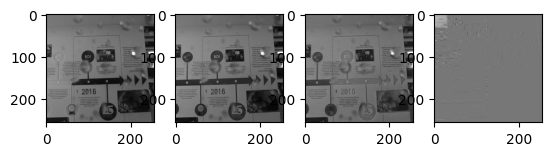

IoU:       0.4751773178577423
Accuracy:  0.937896728515625
Precision: 0.67826247215271
Recall:    0.6134509738638255


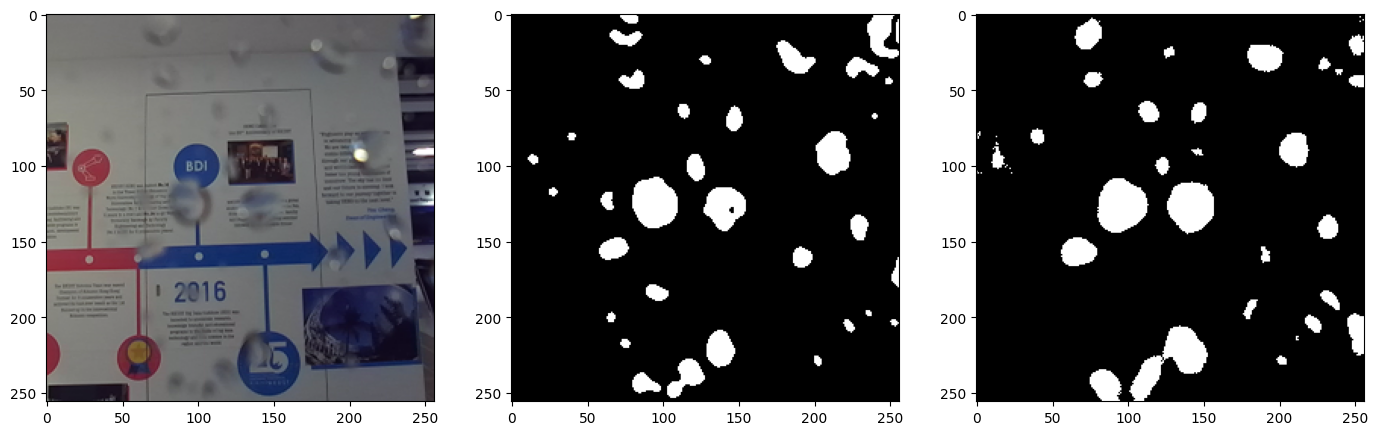

In [51]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
x, y = val_dataset[idx]
show_channels(x)
plot_prediction(x, y, binary_map=True, binary_threshold=config["threshold"])

In [ ]:
# Get prediction from opened image
image_path = "../../data/derain/ALIGNED_PAIRS/CG_DROPLETS/left_1535201264389466.png"
mask_path = "../../data/derain/ALIGNED_PAIRS/CG_MASKS/left_1535201264389466.png"
from PIL import Image, ImageFilter
image = Image.open(image_path)
mask  = Image.open(mask_path)
x, y = dataset.transform(image, mask)
plot_prediction(x, y, binary_map=False)

In [ ]:
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["train_loss"] >= 0.37, save_last=1)

In [12]:
!ls -la cg_checkpoints

total 11644056
drwxrwsr-x 2 kondrashov students      4096 Aug 16 20:03 .
drwxrwsr-x 8 kondrashov students      4096 Aug 17 17:09 ..
-rw-rw-r-- 1 kondrashov students       627 Aug 15 13:33 nullcheck
-rw-rw-r-- 1 kondrashov students 372617517 Aug  9 16:50 UNetAdamBCEt113v71e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt55v57e0.pt
-rw-rw-r-- 1 kondrashov students 372617205 Aug  9 16:52 UNetAdamBCEt57v55e2.pt
-rw-rw-r-- 1 kondrashov students 372617205 Aug  9 16:51 UNetAdamBCEt60v56e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt68v67e2.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt68v68e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt77v60e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt82v68e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt94v68e0.pt
-rw-rw-r-- 1 kondrashov students 372597045 Aug 15 18:05 UNetHSVBCEt14v14e33.pt
-rw-rw-r-- 

In [ ]:
!ls final_models

In [ ]:
!cp checkpoints/UNetRGBSBCEt31v31e56.pt final_models

In [ ]:
def modify_dataset():
    # Modify images to make them smoother
    save_dir = '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7'
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    step = 1
    for path in Path(config["image_dir"]).glob('*.png'):
        image = Image.open(path)
        image = image.filter(ImageFilter.MedianFilter(size = 5))
        new_path = Path(save_dir, path.name)
        image.save(new_path)
        print("Saved", new_path, step)
        step = step + 1

In [34]:
# Remove odd images
from pathlib import Path
def find_odd_files(dir1, dir2):
    for path in Path(dir1).glob('*.png'):
        name = path.name
        other_path = Path(dir2 + '/' + name)
        if not other_path.exists():
            print(other_path, "doesn't exist")
            print("Removed", path)
            path.unlink()

In [35]:
find_odd_files(
    dir1='../../data/stereo/train/image',
    dir2='../../data/stereo/train/mask'
)
find_odd_files(
    dir1='../../data/stereo/train/mask',
    dir2='../../data/stereo/train/image'
)